**Gabriela Tanumihardja**</br>
**Capstone Project - Part III** </br>
**Preliminary Models**

## Table of contents
1. [Loading data](#load)
2. [Data preprocessing](#preprocess)</br>
    2.1 [Data split](#split)</br>
    2.3 [Bag of words](#bow)</br>
3. [Preliminary models](#prelim)</br>
    3.1 [Logistic regression](#logit)</br>
    3.2 [Dimensional Reduction - PCA](#pca)</br>
    3.3 [KNN](#knn)</br>
    3.4 [Decision tree](#dt)</br>
    3.5 [SVM](#svm)
4. [TF-IDF](#tfidf)</br>
    4.1 [PCA optimization](#pcaopt)</br>
    4.2 [Logistic regression](#logittfidf)</br>
    4.3 [KNN](#knntfidf)</br>
    4.4 [SVM](#svmtfidf)</br>
    4.5 [AdaBoost and random forest](#boost)
***

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
import datetime
from sklearn.feature_extraction.text import CountVectorizer
%config InlineBackend.figure_format='retina'
from sklearn.model_selection import train_test_split
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
from nltk.corpus import stopwords
import string
from operator import itemgetter
from wordcloud import WordCloud

%matplotlib inline

***

### Loading data
<a id='load'></a>

In this notebook, I would like to fit some preliminary models for my data. Models that I am looking to fit are:
- Logistic regression
- Decision tree
- KNN
- SVM
- Random Forest
- AdaBoost?

I will begin the exploration by using CountVectorizer but most likely, I will move on to TFIDF as I think it may perform better in my models. I will use the tokenizer I had crafted in the second notebook. At this point in time, I am not planning on doing any optimization. I want to see the baseline performance of each model. I expect I would need to tweak my data after these preliminary fittings. First thing first, loading the data...

In [4]:
# Load the clean csv

df = pd.read_csv('data/clean_df.csv')

In [6]:
# Check!

df.head()

,title,topic,date_published,source,satire
0,Guy who has definitely gotten into a fight at ...,national,2020-08-24T12:20:03-04:00,beaverton,1
1,Party that wants to manage government can’t ma...,national,2020-08-24T09:49:25-04:00,beaverton,1
2,Canada searches for new country to compare our...,national,2020-08-21T15:14:56-04:00,beaverton,1
3,Trudeau hopes giving Parliament five week vaca...,national,2020-08-18T19:08:42-04:00,beaverton,1
4,Highlights of Andrew Scheer’s tenure as Conser...,national,2020-08-17T11:34:45-04:00,beaverton,1


***

### Data Preprocessing
<a id='preprocess'></a>

#### Data split
<a id='split'></a>

Some preprocessing is needed to be done first. I will separate the data to predictor (title) and target (satire).

In [7]:
# Specify X and y

X = df['title']
y = df['satire']

In [8]:
# Check!

X

0        Guy who has definitely gotten into a fight at ...
1        Party that wants to manage government can’t ma...
2        Canada searches for new country to compare our...
3        Trudeau hopes giving Parliament five week vaca...
4        Highlights of Andrew Scheer’s tenure as Conser...
                               ...                        
46093    Hugh Hefner Comes Out of Retirement, Changes P...
46094         Nine Drawn and Quartered at Renaissance Fair
46095                               Congress Hires Drummer
46096                                          Sonic Booms
46097                                  Your Real Horoscope
Name: title, Length: 46098, dtype: object

In [9]:
# Check!

y

0        1
1        1
2        1
3        1
4        1
        ..
46093    1
46094    1
46095    1
46096    1
46097    1
Name: satire, Length: 46098, dtype: int64

I will now perform a train test split on my data. I will first split the data to remainder and test. I will reserve the test set for my final model. From the remainder set, I will split it into a train set and a validation set. I will stratify each split by the satire classes. I have a sizeable data, so I will set aside 10% for each test and validation (10% of remainder set in this case).

In [11]:
# Split into remainder and test

X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size = 0.1, random_state = 99, stratify = y)

In [12]:
# Split into train and validation

X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size = 0.1, random_state = 99, stratify = y_rem)

In [16]:
# Reset indices for easier handling

dfs = [X_rem, X_train, X_val, X_test, y_rem, y_train, y_val, y_test]

for df in dfs:
    df.reset_index(inplace = True, drop = True)

In [17]:
# Check!

X_rem.shape

(41488,)

In [20]:
# Check!

X_val.shape

(4149,)

***
#### Bag of Words
<a id='bow'></a>

Each set seems to be appropriately sized and they seem to be split correctly. I will now define my tokenizer. I will be using the exact same tokenizer as before.

In [26]:
# specify stop words

ENGLISH_STOP_WORDS = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [27]:
# My-Trusty-Tokenizer

def my_tokenizer(sentence):
    
    # translation of pos_tag label to wordnet's label
    t_map = defaultdict(lambda : wn.NOUN)
    t_map['J'] = wn.ADJ
    t_map['V'] = wn.VERB
    t_map['R'] = wn.ADV

    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.replace(punctuation_mark,'').replace('  ' , ' ').lower()
    
    # remove any first and last empty spaces
    sentence = re.sub('^ ', '', sentence)
    sentence = re.sub(' $', '', sentence)
        
    # split sentence into words
    listofwords = sentence.split(' ')
    listoflemmas = []
    
    # get each word's pos_tag
    tagged = pos_tag(listofwords)

    # Remove stopwords and any tokens that are just empty strings
    for word, tag in tagged:
        # remove stop words, empty words and more spaces 
        if (not word in ENGLISH_STOP_WORDS) and (word!='') and (word != ' '):
            # Turn words to lemmas - according to their wn labels
            lemma = lemmatizer.lemmatize(word, t_map[tag[0]])
            listoflemmas.append(lemma)

    return listoflemmas

I will now transform my data. I will be using count vectorizer for now. I will fit the count vectorizer on the train set and transform both the train set, remainder set, and the validation set. I will be transforming the remainder set to use in cross validation instances. I will use a min_df of 10, taking into account only words that appear at least 10 times in the whole document.

In [28]:
### TRAINING SET! ###

# 1. Instantiate
bagofwords = CountVectorizer(min_df = 10, tokenizer = my_tokenizer)

# 2. Fit
bagofwords.fit(X_train)

# 3.1 Transform train set
X_train_transformed = bagofwords.transform(X_train)

# 3.2 Transform validation set

X_val_transformed = bagofwords.transform(X_val)

X_rem_transformed = bagofwords.transform(X_rem)

In [29]:
# Turn to df

X_train_df = pd.DataFrame(X_train_transformed.todense(), columns = bagofwords.get_feature_names())

X_val_df = pd.DataFrame(X_val_transformed.todense(), columns = bagofwords.get_feature_names())

X_rem_df = pd.DataFrame(X_rem_transformed.todense(), columns = bagofwords.get_feature_names())

In [30]:
# Check!

print(f'Train shape: {X_train_df.shape}')
print(f'Remainder shape: {X_rem_df.shape}')
print(f'Val shape: {X_val_df.shape}')

Train shape: (37339, 4196)
Remainder shape: (41488, 4196)
Val shape: (4149, 4196)


Looking good! I will now move on and start fitting models.

***
### Preliminary Models
<a id='prelim'></a>
#### Logit
<a id='logit'></a>

I will now start a logistic regression model. This model, while condsiered the simplest, is the most interpretable. I think it is a very good place to start as I could pull out the most predictive words and see whether further data manipulation is needed. (Keeping in mind possible biases from cleaning.) I will be using the default logistic regression for this initial model (lbfgs, C = 1).

In [31]:
from sklearn.linear_model import LogisticRegression

# 1 Instantiate

logit = LogisticRegression()

# 2 Fit

logit.fit(X_train_df, y_train)

/Users/gabrielatanumihardja/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [32]:
# 3 Score

print(f'Score of training: {logit.score(X_train_df, y_train)}')
print(f'Score of validation: {logit.score(X_val_df, y_val)}')

Score of training: 0.8800449931706794
Score of validation: 0.8339358881658231


Wow, that result is very high. I certainly did not expect it, I am rather skeptical to the actual reason for this very high result. Thankfully, with logit, I could pull out the coefs and see what the model is actually predicting. (Thank goodness for regressions 🎉🎉) I will begin the evaluation by making predictions and constructing a confusion matrix.

In [41]:
# Make predictions for the validation set

y_pred = logit.predict(X_val_df)

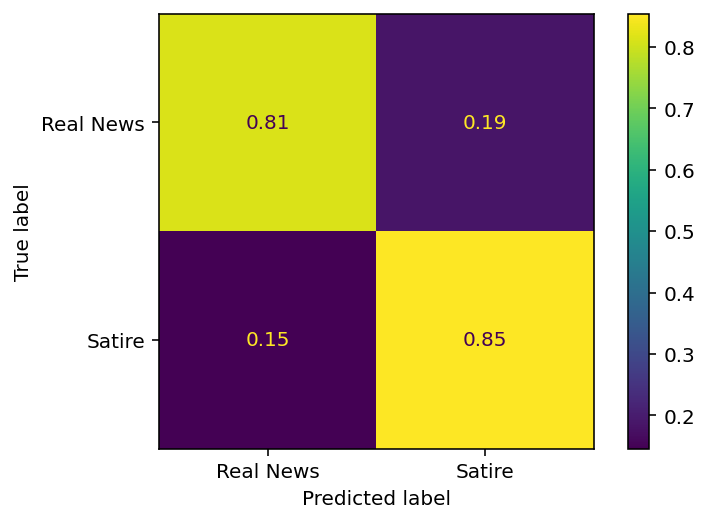

In [42]:
# Confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix_train = confusion_matrix(y_val, y_pred, normalize= 'true')

ConfusionMatrixDisplay(conf_matrix_train, display_labels = ['Real News', 'Satire']).plot();

From the confusion matrix, it seems that this model has pretty equal false positive and false negative. There isn't any glaring red flag from the matrix. Next I will check the classification report to see the model's precision and recall.

In [46]:
# Print classification report

from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred, target_names = ['Real News', 'Satire']))

              precision    recall  f1-score   support

   Real News       0.85      0.81      0.83      2087
      Satire       0.82      0.85      0.84      2062

    accuracy                           0.83      4149
   macro avg       0.83      0.83      0.83      4149
weighted avg       0.83      0.83      0.83      4149



From the classification report, both precision and recall are over 80% with this model. Good results overall so far. I will now pull out the most predictive words for each class.

In [47]:
print('REAL NEWS PREDICTIVE WORDS:')
print(pd.DataFrame(logit.coef_, columns = X_train_df.columns).sum(axis = 0).sort_values(ascending = True).head(10))

REAL NEWS PREDICTIVE WORDS:
covid19       -4.007041
pandemic      -3.509372
virus         -3.363948
coronavirus   -3.236955
reopen        -2.901145
tiktok        -2.869512
biden’s       -2.767487
dy            -2.666737
beirut        -2.609527
netflix’s     -2.596621
dtype: float64


In [48]:
print('SATIRES PREDICTIVE WORDS:')
print(pd.DataFrame(logit.coef_, columns = X_train_df.columns).sum(axis = 0).sort_values(ascending = False).head(10))

SATIRES PREDICTIVE WORDS:
horoscope    4.839776
onion        3.496375
bush         3.308721
harper       3.212575
fuck         3.061016
assure       2.900931
clinton      2.823829
2013         2.684570
realize      2.664350
area         2.599984
dtype: float64


The words from each class seem to be mostly okay. There are some red-flags in the satire group, however. It seems that, eventhough it only represents 1% of the whole data, horoscope articles became the most predictive factor for satire. I think this needs to be addressed by modifying the data further. The second predictor is 'onion' which is also not ideal. Another word that I would like to modify is 2013. I want my model to be relatively timeless, so the fact that 2013 shows up in the top 10 most predictive words is undesirable. I will also check the year from which all the headlines are from. From here, however, I would like to forge on and continue fitting models on this dataset, to get a feel of the dataset more. But first, I would like to know how many articles actually contain the word 'Onion'?

In [54]:
# How many Onions?

with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    print(len(X_rem[X_rem.str.contains('Onion')]))

150


There are only 150 articles with the word 'Onion' in it. That is very low, considering we have over 40,000 articles. This solidifies my inkling that I need to remove this word, and I don't think TFIDF would fix this problem.

***
#### PCA
<a id='pca'></a>

In [58]:
# How many tokens are there?

X_rem_df.shape

(41488, 4196)

From here, I would like to fit KNN and SVM. I would like to perform PCA on my variables first, however, as there are more than 4,000 tokens and it would take a long time to train these models. At this point, I will be preserving 80% of the variance in the resulting reduced variables.

In [59]:
from sklearn.decomposition import PCA


# 1. Instantiate
# keep 80% of variance
pca = PCA(n_components = 0.8)

# 2. Fit

pca.fit(X_train_df)

# 3. Transform

X_train_pca = pca.transform(X_train_df)
X_val_pca = pca.transform(X_val_df)
X_rem_pca = pca.transform(X_rem_df)

In [62]:
# Check!

X_rem_pca.shape

(41488, 1518)

Great! With PCA, my data now only has 1,518 columns whilst still preserving 80% of the original's variance. This will reduce any noise as well as help us reduce training time.

***

#### KNN
<a id='knn'></a>

I will now fit a KNN model to my data. I will be using the reduced data, and set a n_jobs = -1. I am expecting the scoring time to be significantly longer than logit. I will keep number of neighbors to be 2 for now. 

In [64]:
from sklearn.neighbors import KNeighborsClassifier

# 1. Instantiate

knn = KNeighborsClassifier(n_neighbors = 2, n_jobs = -1)

# 2. Fit

knn.fit(X_train_pca, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=2)

In [65]:
# 3. Score - Train

%%time

knn.score(X_train_pca, y_train)

CPU times: user 1h 33min 31s, sys: 8.23 s, total: 1h 33min 39s
Wall time: 24min 49s


0.8532633439567209

In [66]:
# 3. Score - Val

%%time

knn.score(X_val_pca, y_val)

CPU times: user 10min 50s, sys: 940 ms, total: 10min 51s
Wall time: 2min 53s


0.6654615570016872

This model is very much overfitted, I will now do a simple search to see if altering the number of neighbors will increase the validation score.

In [67]:
# empty list to store scores
knn_scores = []

# number of neighbors
neighbors = np.arange(1,32, 2)

# loop
for neighbor in neighbors:
    
    knn = KNeighborsClassifier(n_neighbors = neighbor, n_jobs = -1)
    
    knn.fit(X_train_pca, y_train)
    
    score = knn.score(X_val_pca, y_val)
    
    knn_scores.append(score)
    
    print(f'neighbor = {neighbor}, score = {score}')

neighbor = 1, score = 0.6789587852494577
neighbor = 3, score = 0.6845022897083635
neighbor = 5, score = 0.6816100265124126
neighbor = 7, score = 0.6842612677753676
neighbor = 9, score = 0.6914919257652447
neighbor = 11, score = 0.6994456495541094
neighbor = 13, score = 0.6994456495541094
neighbor = 15, score = 0.7030609785490479
neighbor = 17, score = 0.6989636056881177
neighbor = 19, score = 0.6982405398891299
neighbor = 21, score = 0.6982405398891299
neighbor = 23, score = 0.6936611231622077
neighbor = 25, score = 0.6939021450952036
neighbor = 27, score = 0.6946252108941914
neighbor = 29, score = 0.6893227283682816
neighbor = 31, score = 0.6888406845022897


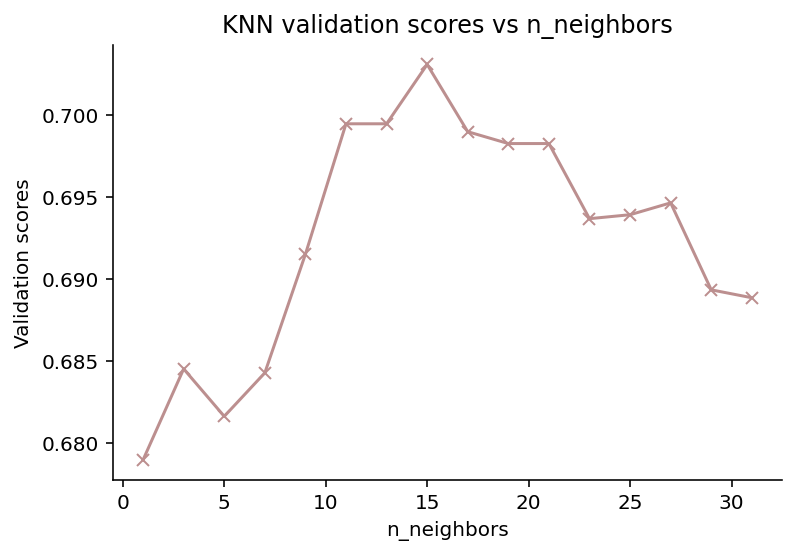

In [68]:
# Graph the validation scores

plt.figure()
plt.plot(neighbors, knn_scores, marker = 'x', color = 'rosybrown')
sns.despine()
plt.xlabel('n_neighbors')
plt.ylabel('Validation scores')
plt.title('KNN validation scores vs n_neighbors')
plt.show()

I didn't use cross validation here, it took a very long time to score these KNN models. In this case, the number of neighbors didn't seem to improve the score very much, and the accuracies aren't better than the logistic regression model. Maybe with further optimizations with KNN will improve the score, however I will move on to DTs for now.

***

#### Decision Tree
<a id='dt'></a>

I will naively fit a DT model without any optimization and let it run until it overfits and have a training accuracy of 1, before start trimming. I will be using the original data for this model to conserve as much interpretability as I could.

In [69]:
# Decision tree

from sklearn.tree import DecisionTreeClassifier

# 1. Instantiate

dt = DecisionTreeClassifier()

# 2. Fit

dt.fit(X_train_df, y_train)

DecisionTreeClassifier()

In [70]:
# 3. Score

print(f'Train score = {dt.score(X_train_df,y_train)}')

print(f'Validation score = {dt.score(X_val_df, y_val)}')

Train score = 0.996089879214762
Validation score = 0.7481320800192818


In [71]:
# How many layers?

dt.tree_.max_depth

1983

This model is very overfitted, as expected. The result from this model is not too bad, a 75%, considering how overfitted the model was. It took a considerable amount of time to train this model, so I am not going to optimize this model. I am interested in fitting a similar model to my model, such as XGBoost and random forest. For now, I will move on to SVM.

***

#### SVM
<a id='svm'></a>

For SVM models, I will be using the reduced data, once again. From the research that I have done, SVM has been very popular in classifying sentiments with NLP. I will be fitting both an rbf kernel model and linear model.

In [74]:
# rbf kernel

from sklearn.svm import SVC

# 1. Instantiate

svc = SVC()

# 2. Fit

svc.fit(X_train_pca, y_train)

SVC()

In [75]:
# 3. Score

print(f'Train score: {svc.score(X_train_pca, y_train)}')
print(f'Validation score: {svc.score(X_val_pca, y_val)}')

Train score: 0.9220654007873805
Validation score: 0.8259821643769583


In [76]:
# linear kernel

from sklearn.svm import LinearSVC

# 1. Instantiate

lin_svc = LinearSVC()

# 2. Fit

lin_svc.fit(X_train_pca, y_train)

# 3. Score

print(f'Train score: {lin_svc.score(X_train_pca, y_train)}')
print(f'Validation score: {lin_svc.score(X_val_pca, y_val)}')

Train score: 0.838908379978039
Validation score: 0.8124849361291877


The results of the Support Vector Machines are very promising, however it did took a considerable amount of time to score this model. I will not be tuning any hyperparameter for now.

***

#### Trying TF-IDF

Let's try TF-IDF to tokenize the data. Because TF-IDF put less weight in words that appear often, maybe this will reduce the effect of 'Onion' and 'horoscope'? I will keep the min_df as 10 and use my trusty tokenizer.

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Instantiate

tfidf = TfidfVectorizer(min_df=10, tokenizer=my_tokenizer)

# 2. Fit

tfidf.fit(X_train)

# 3. Transform

X_train_tfidf = tfidf.transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_rem_tfidf = tfidf.transform(X_rem)

/Users/gabrielatanumihardja/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [65]:
# Check!

X_train_tfidf.shape

(37339, 4196)

In [70]:
# Turn to df

X_train_tfidf_df = pd.DataFrame(X_train_tfidf.todense(), columns = tfidf.get_feature_names())
X_rem_tfidf_df = pd.DataFrame(X_rem_tfidf.todense(), columns = tfidf.get_feature_names())
X_val_tfidf_df = pd.DataFrame(X_val_tfidf.todense(), columns = tfidf.get_feature_names())

In [71]:
# Check!

X_train_tfidf_df.sample(5)

,1,10,100,1000,10000,100000,10th,11,11th,12,...,‘not,‘star,‘the,‘this,‘we,‘we’re,‘what,‘you,’em,…
5866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


From here, I will run KNN and SVM again. I will try out AdaBoost and Random Forest instead of the regular decision tree. I also need to apply PCA on my TF-IDF data. First I want to see whether setting the n_components to 80% is fair. I will fit PCA with all the components (4,196) and transform the data. From here I will plot the explained_variance_ratio vs the number of components. On this graph, I am looking for a sharp elbow for which is the number of component I should choose.

***
#### PCA optimization
<a id='pcaopt'></a>

In [82]:
# Fit PCA with all components

pca0 = PCA(n_components = 4196)
pca0.fit(X_train_tfidf_df)

PCA(n_components=4196)

In [83]:
# transform data 

X_train_tf_pca0 = pca0.transform(X_train_tfidf_df)

In [84]:
# get the explained variance ratios

expl_var = pca0.explained_variance_ratio_
print(expl_var)

[5.77305749e-03 4.07765449e-03 3.81371936e-03 ... 8.98746459e-06
 3.13744741e-06 1.13853484e-33]


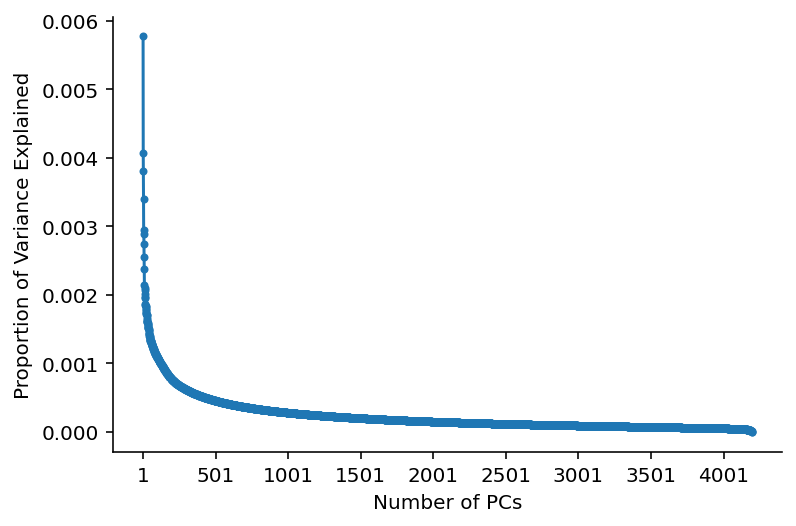

In [85]:
# plot explained variance ratios vs number of components

plt.figure()
plt.plot(range(1, 4197),expl_var,marker='.')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,4197,500))
sns.despine()
plt.show()

There is no sharp elbow on this graph, maybe if I zoom in.

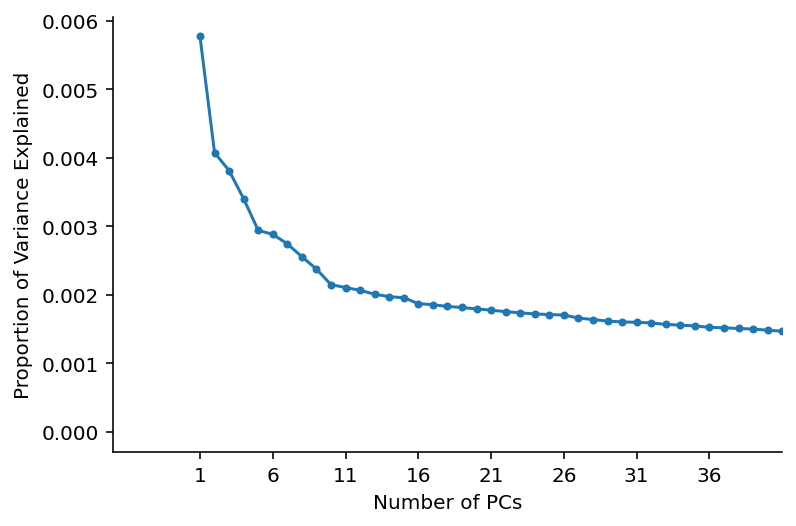

In [86]:
# zooming in

plt.figure()
plt.plot(range(1, 4197),expl_var,marker='.')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xlim(-5, 41)
plt.xticks(range(1,41,5))
sns.despine()
plt.show()

There is still no clear number of components from these explorations, however it seems that the initial drop occurs before 21 components. I will now get the cummulative sum of the explained variance ratios. I am looking at how much variance do these 20 components explain cummulatively?

In [87]:
expl_var_cumulative = pca0.explained_variance_ratio_.cumsum()
print(expl_var_cumulative[0:20])

[0.00577306 0.00985071 0.01366443 0.01706851 0.02000998 0.02289381
 0.02563871 0.02819631 0.0305729  0.03272209 0.0348297  0.03689567
 0.03890586 0.04087976 0.04283755 0.04471002 0.04656598 0.04839692
 0.05021273 0.05200748]


The first 20 components only account for 5% of the variance! There are so many variables and each variable add a tiny bit of variance. From the plot, it can be seemn that the first component only account for 0.6% of variance. I think I will stick to setting n_components to be 0.8. Now I will create a scale and reduce pipeline that will scale and apply PCA to thethe TF-IDF data.

In [77]:
# Make a scale and reduce pipeline

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scale_pca_pipe = make_pipeline(StandardScaler(), PCA(n_components = 0.8))

I will start using a cross validation method and take the average score as the accuracy marker. I will start with a logit.

***
#### TF-IDF logit
<a id='logittfidf'></a>

In [72]:
from sklearn.model_selection import cross_val_score

scores_logit = cross_val_score(logit, X_rem_tfidf_df, y_rem, cv = 5)

print(f'Average Score:{np.mean(scores_logit)}')

Average Score:0.8346993702376055


There doesn't seem to be much difference in accuracies between count vectorized data and TF-IDF data. I will now move on to KNN and SVC

***
#### TF-IDF KNN
<a id='knntfidf'></a>

I will move on to fitting KNN model with TF-IDF processed data. First I will put the data into my scale reduce pipeline.

In [78]:
# Transform train and validation data (scale and transform)

X_train_tfidf_scaled = scale_pca_pipe.fit_transform(X_train_df)

X_val_tfidf_scaled = scale_pca_pipe.transform(X_val_df)

Now, I will instantiate, fit, and score a KNN model to the scaled TF-IDF data. I will keep the default n_neighbors of 5.

In [80]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate

knn = KNeighborsClassifier(n_jobs = -1)

# Fit rbf KNN

knn.fit(X_train_tfidf_scaled, y_train)

# Score

print(f'Score of training: {knn.score(X_train_tfidf_scaled, y_train)}')
print(f'Score of validation: {knn.score(X_val_tfidf_scaled, y_val)}')

Score of training: 0.8099306355285358
Score of validation: 0.6869125090383225


It seems that the scores are very similar between the TF-IDF data and count vectorized data. For n_neighbors of 5, TF-IDF data has a validation score of 0.69 and count vec data has a validation score of 0.68.

***
#### TF-IDF SVM
<a id='svmtfidf'></a>

Next I will fit SVM models with TF-IDF processed data. After putting the data through my scale and reduce pipeline, I will fit a linear and rbf kernel SVM models.

In [110]:
# Fit linear SVM

lin_svc.fit(X_train_tfidf_scaled, y_train)

# Score

print(f'Score of training: {lin_svc.score(X_train_tfidf_scaled, y_train)}')
print(f'Score of validation: {lin_svc.score(X_val_tfidf_scaled, y_val)}')

/Users/gabrielatanumihardja/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Score of training: 0.818259728434077
Score of validation: 0.7823571945047


In [111]:
# Fit rbf SVM

svc.fit(X_train_tfidf_scaled, y_train)

# Score

print(f'Score of training: {svc.score(X_train_tfidf_scaled, y_train)}')
print(f'Score of validation: {svc.score(X_val_tfidf_scaled, y_val)}')

Score of training: 0.9260290848710464
Score of validation: 0.8303205591708845


The results from TF-IDF data appear to be slightly lower than the count vectorized data. This is expected as it seems that the count vectorized data is biased by the very specific words. At this point, I will fit two final preliminary models, AdaBoost and Random Forest, before tweaking the data.

***
#### AdaBoost and RandomForest
<a id='boost'></a>

I will be fitting both AdaBoost and RandomForest to both CountVectorized data and TF-IDF data. I expect that Random Forest will be much less overfitted than the decision tree I fitted earlier, as they use many many decision stumps.

In [150]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


# TF-IDF
AB_model = AdaBoostClassifier()
RF_model = RandomForestClassifier()

AB_model.fit(X_train_tfidf_scaled, y_train)
RF_model.fit(X_train_tfidf_scaled, y_train)

print("Train Set Scores:")
print(f"AdaBoost score: {AB_model.score(X_train_tfidf_scaled, y_train)}")
print(f"Random Forest score: {RF_model.score(X_train_tfidf_scaled, y_train)}")

print("Test Set Scores:")
print(f"AdaBoost score: {AB_model.score(X_val_tfidf_scaled, y_val)}")
print(f"Random Forest score: {RF_model.score(X_val_tfidf_scaled, y_val)}")

Train Set Scores:
AdaBoost score: 0.7819438120999491
Random Forest score: 0.996089879214762
Test Set Scores:
AdaBoost score: 0.7736804049168474
Random Forest score: 0.7760906242468064


In [152]:
# CountVectorizer
AB_model = AdaBoostClassifier()
RF_model = RandomForestClassifier()

AB_model.fit(X_train_pca, y_train)
RF_model.fit(X_train_pca, y_train)

print("Train Set Scores:")
print(f"AdaBoost score: {AB_model.score(X_train_pca, y_train)}")
print(f"Random Forest score: {RF_model.score(X_train_pca, y_train)}")

print("Test Set Scores:")
print(f"AdaBoost score: {AB_model.score(X_val_pca, y_val)}")
print(f"Random Forest score: {RF_model.score(X_val_pca, y_val)}")

Train Set Scores:
AdaBoost score: 0.7345670746404563
Random Forest score: 0.996089879214762
Test Set Scores:
AdaBoost score: 0.7225837551217161
Random Forest score: 0.759701132803085


The random forest models I just fitted are still quite overfitted, I would need to tweak the number of trees. There doesnt seem to be much difference in validation scores for these scores between the CountVectorized and TF-IDF data. I think this is a good point to stop modelling and finesse the data. I will:
- Resample the data - all the published year should be somewhat balance
- Replace 'Onion' and numbers on the headlines - numbers should be hashed, and the word 'Onion' could be deleted.

**On to pt.4 - Adjust Data**